<a href="https://colab.research.google.com/github/savadsvd/plant-disease-detection/blob/main/plant_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PLANT** **DISEASE** **DETECTION**

**Import Used Libraries**

In [ ]:
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers  import Concatenate
from keras.layers import AveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow import keras
from keras import layers
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob as gb

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2 as cv

insert the path in which the trainind data lies
the below cell will return a dictionary of key value pairs of images and labels

note: we have seperate validation data so there is no need to split the dataset into seperate datasets

In [ ]:
train_dir='/content/drive/MyDrive/new/valid'
valid_dir='/content/drive/MyDrive/new/valid'
test_dir="/content/drive/MyDrive/new/test/test"
diseases = os.listdir(train_dir)
print(diseases)

['Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy', 'Apple___Cedar_apple_rust', 'Apple___healthy']


**ABOUT DATASET**

 This dataset consists of about 9K rgb images of healthy and diseased crop leaves which is categorized into 18 different classes. The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structure. A new directory containing 30 test images is created later for prediction purpose

In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
print(plants)
print(len(plants))
print(NumberOfDiseases)

['Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Peach', 'Pepper,_bell', 'Potato', 'Strawberry', 'Tomato', 'Apple']
9
9


So we have images of leaves of 9 plants and while excluding healthy leaves, we have 9 types of images that show a particular disease in a particular plant.

In [ ]:
# Number of images for each disease
numberof_images={}
for disease in diseases:
    numberof_images[disease]=len(os.listdir(train_dir+"/"+disease))
images_each_class=pd.DataFrame(numberof_images.values(),index=numberof_images.keys(),columns=["Number of images"])
images_each_class

Number of images
Cherry_(including_sour)___healthy                    456
Corn_(maize)___Common_rust_                          477
Corn_(maize)___healthy                               465
Grape___Black_rot                                    472
Grape___healthy                                      423
Peach___Bacterial_spot                               459
Peach___healthy                                      432
Pepper,_bell___Bacterial_spot                        478
Pepper,_bell___healthy                               497
Potato___Early_blight                                485
Potato___healthy                                     456
Strawberry___Leaf_scorch                             444
Strawberry___healthy                                 456
Tomato___Early_blight                                480
Tomato___Tomato_Yellow_Leaf_Curl_Virus               490
Tomato___healthy                                     481
Apple___Cedar_apple_rust                             814
Apple___healthy                                     1008

In [ ]:
Size=224
X_test=[]
y_test=[]

Preparing Images For Training By Image Preprocessing

In [ ]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1/255.0,
    validation_split=0.15
).flow_from_directory(train_dir,batch_size=16,target_size=(Size,Size),subset="training",shuffle=True)

Found 7891 images belonging to 18 classes.


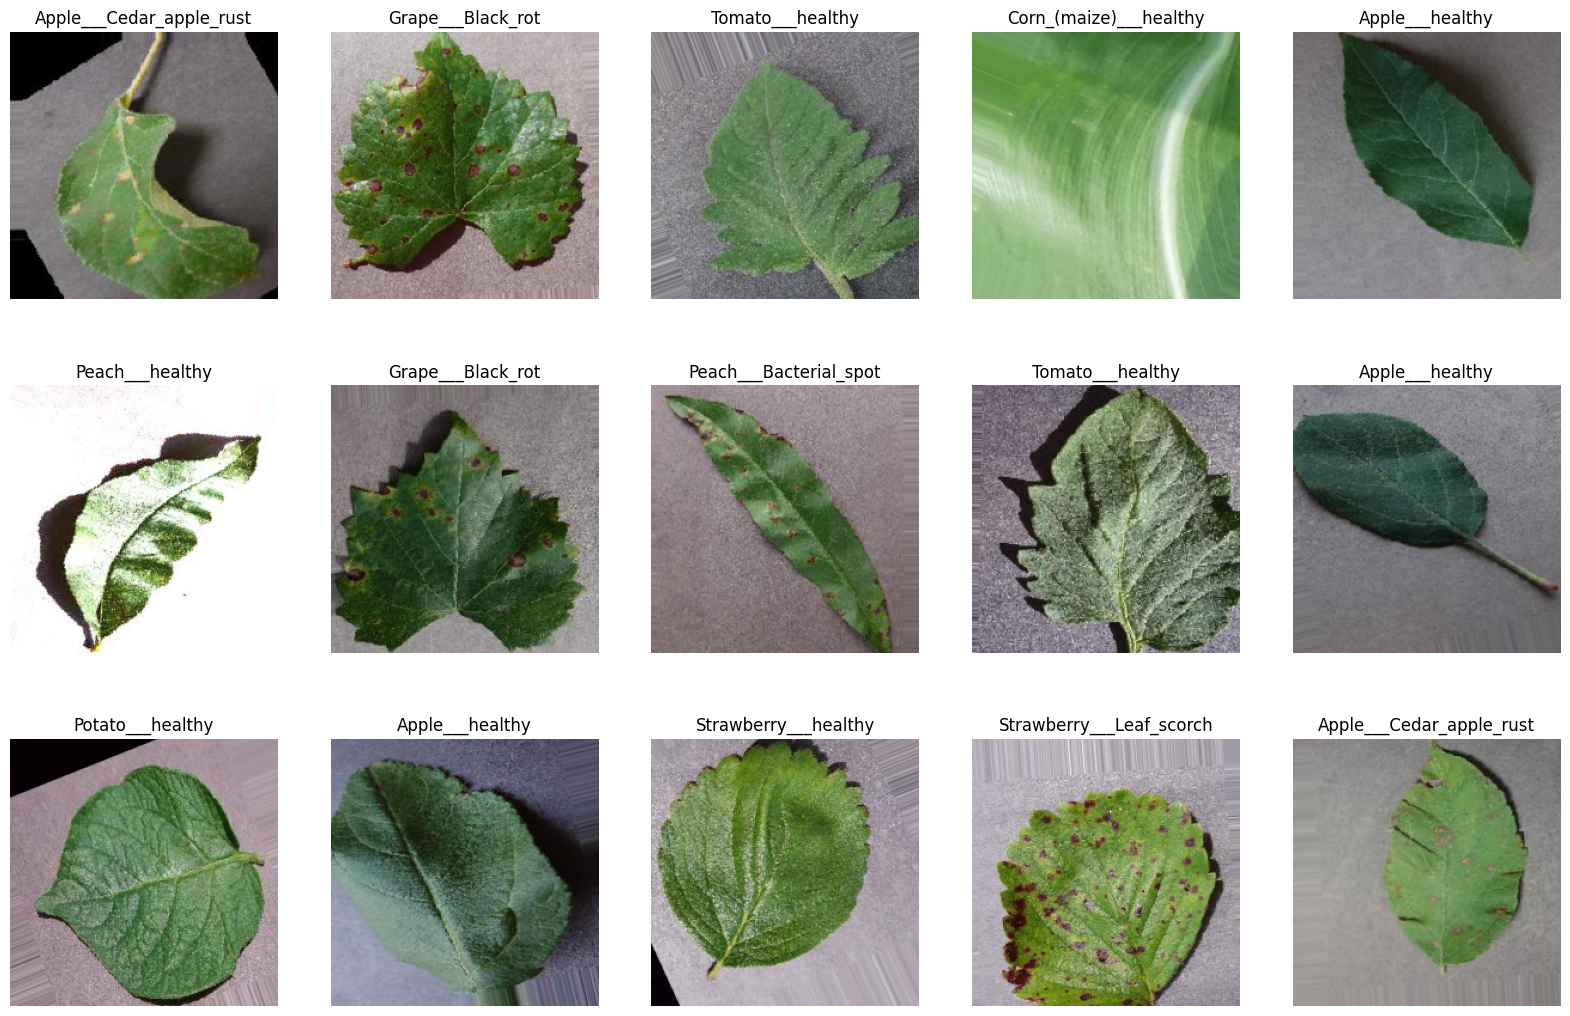

In [ ]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,13))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,15):
        plt.subplot(3,5,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
        plt.axis('off')
    # show the plot
    plt.show()
    break

In [ ]:
valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.15
).flow_from_directory(train_dir,batch_size=16,target_size=(Size,Size),subset='validation',shuffle=False)

Found 1382 images belonging to 18 classes.


In [ ]:
X_test=[]
for folder in os.listdir(test_dir):
    files=gb.glob(test_dir+'/*.JPG')
    for file in files :
        img=cv.imread(file)
        X_test.append(cv.resize(img,(Size,Size)))

In [ ]:
X_test=np.array(X_test)
X_test=X_test/255.0

**defining** **model** **Transfer** **learning** **with** **VGG**-**16** 

In [ ]:
base_model=VGG16(include_top=False,input_shape=(224,224,3))
base_model.trainable=False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Build a model by channing the base_model layer and Dense layers**

In [ ]:
classifier=Sequential()
classifier.add(base_model)
classifier.add(Flatten())
classifier.add(Dense(18,activation='softmax'))
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 18)                451602    
                                                                 
Total params: 15,166,290
Trainable params: 451,602
Non-trainable params: 14,714,688
_________________________________________________________________


**Compile and train the model**

In [ ]:
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from sqlalchemy import true
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode="min",patience=5,restore_best_weights=True)

In [ ]:
history = classifier.fit(train_generator,
                         steps_per_epoch=len(train_generator)//8,
                         validation_data=valid_generator,
                         epochs=12,
                         validation_steps=len(valid_generator)//8,callbacks=callback,verbose=1
                         )

Epoch 1/12
61/61 [==============================] - 56s 924ms/step - loss: 0.2949 - accuracy: 0.9191 - val_loss: 0.2068 - val_accuracy: 0.9250
Epoch 2/12
61/61 [==============================] - 46s 751ms/step - loss: 0.3791 - accuracy: 0.9078 - val_loss: 0.0915 - val_accuracy: 0.9812
Epoch 3/12
61/61 [==============================] - 39s 638ms/step - loss: 0.2817 - accuracy: 0.9303 - val_loss: 0.3003 - val_accuracy: 0.9062
Epoch 4/12
61/61 [==============================] - 41s 674ms/step - loss: 0.2320 - accuracy: 0.9375 - val_loss: 0.1856 - val_accuracy: 0.9375
Epoch 5/12
61/61 [==============================] - 36s 587ms/step - loss: 0.2638 - accuracy: 0.9191 - val_loss: 0.0562 - val_accuracy: 0.9812
Epoch 6/12
61/61 [==============================] - 33s 544ms/step - loss: 0.1770 - accuracy: 0.9344 - val_loss: 0.0700 - val_accuracy: 0.9812
Epoch 7/12
61/61 [==============================] - 33s 534ms/step - loss: 0.1816 - accuracy: 0.9447 - val_loss: 0.3716 - val_accuracy: 0.8938

**Save the model**

In [ ]:
from keras.models import load_model
my_saved = classifier.save("/content/drive/MyDrive/new/plant.h5")

In [ ]:
#new_model_=keras.models.load_model('plant.h5')

In [ ]:
hist=history.history

Text(0, 0.5, 'Loss')

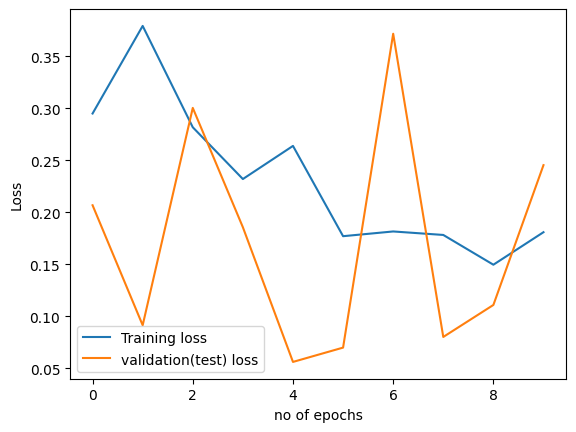

In [ ]:
plt.plot(hist['loss'],label='Training loss')
plt.plot(hist['val_loss'],label='validation(test) loss')
plt.legend()
plt.xlabel('no of epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'accuracy')

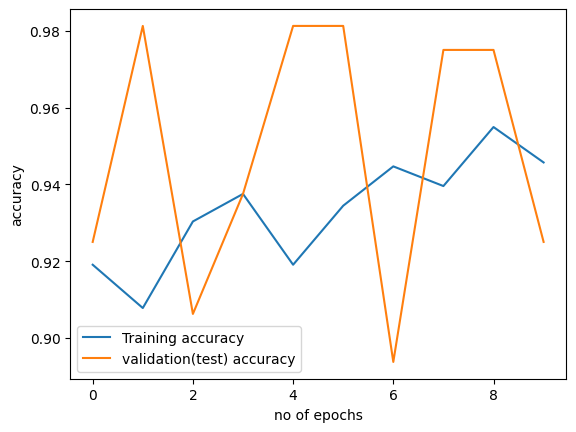

In [ ]:
plt.plot(hist['accuracy'],label='Training accuracy')
plt.plot(hist['val_accuracy'],label='validation(test) accuracy')
plt.legend()
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

In [ ]:
predictions=classifier.predict(valid_generator)

87/87 [==============================] - 359s 4s/step


In [ ]:
predictions

array([[9.9994063e-01, 5.4324828e-05, 8.4900114e-09, ..., 7.7131624e-08,
        3.2837299e-11, 1.9799293e-08],
       [9.9996781e-01, 1.0847339e-09, 2.0250049e-08, ..., 9.5012460e-08,
        2.0223319e-10, 6.3853978e-11],
       [9.9999869e-01, 3.0086997e-07, 1.7015569e-07, ..., 3.5597467e-09,
        1.9950361e-13, 2.7092849e-13],
       ...,
       [1.3015095e-04, 1.3312685e-12, 7.0856103e-09, ..., 2.1124135e-04,
        5.1774318e-09, 9.9892277e-01],
       [2.6754329e-01, 8.3999382e-03, 2.2068063e-03, ..., 3.8302515e-02,
        1.4679540e-06, 6.7741293e-01],
       [2.5142502e-02, 4.6903060e-05, 3.4312869e-04, ..., 4.3346310e-07,
        1.8097374e-10, 7.6576751e-01]], dtype=float32)

In [ ]:
print(classification_report(valid_generator.classes, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       122
           1       0.99      0.95      0.97       151
           2       0.91      0.99      0.94        68
           3       1.00      0.77      0.87        71
           4       0.99      1.00      0.99        69
           5       1.00      0.96      0.98        70
           6       0.90      1.00      0.95        63
           7       0.97      0.88      0.92        68
           8       0.91      0.95      0.93        64
           9       0.92      0.68      0.78        71
          10       0.66      0.96      0.78        74
          11       0.81      0.97      0.89        72
          12       0.97      0.82      0.89        68
          13       1.00      0.85      0.92        66
          14       0.98      0.88      0.93        68
          15       0.62      0.97      0.76        72
          16       1.00      0.81      0.89        73
          17       1.00    

**Predict the test image**

In [ ]:
Test_images = sorted(os.listdir(test_dir))
Test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

1/1 [==============================] - 1s 795ms/step


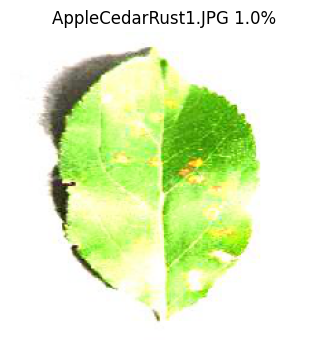

1/1 [==============================] - 0s 19ms/step


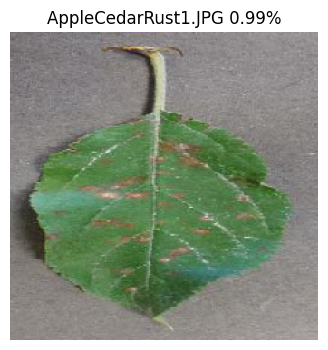

1/1 [==============================] - 0s 22ms/step


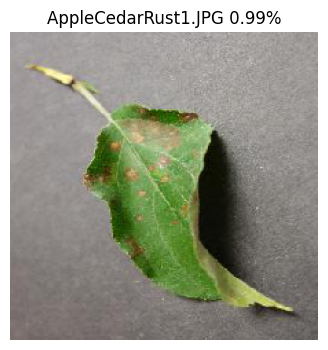

1/1 [==============================] - 0s 24ms/step


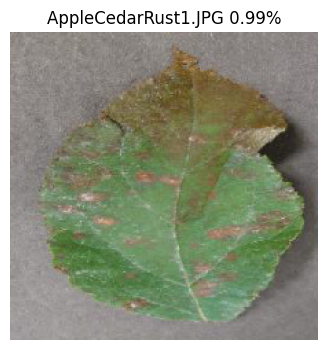

1/1 [==============================] - 0s 21ms/step


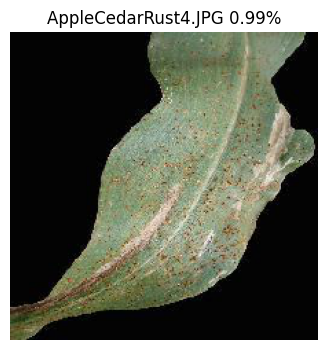

1/1 [==============================] - 0s 32ms/step


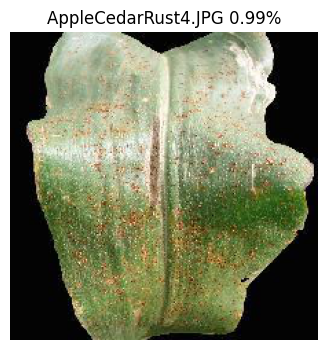

1/1 [==============================] - 0s 22ms/step


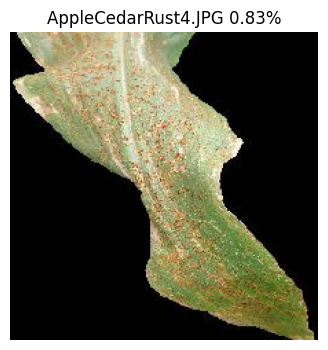

1/1 [==============================] - 0s 20ms/step


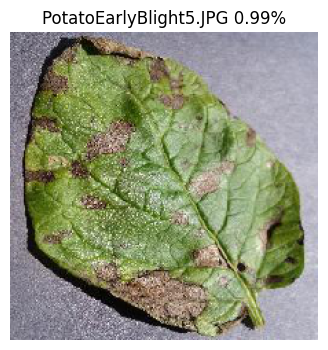

1/1 [==============================] - 0s 25ms/step


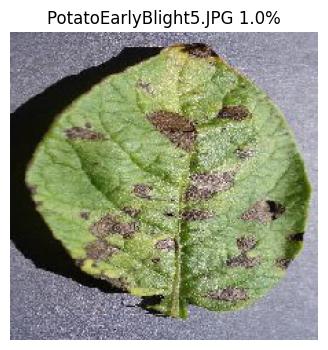

1/1 [==============================] - 0s 34ms/step


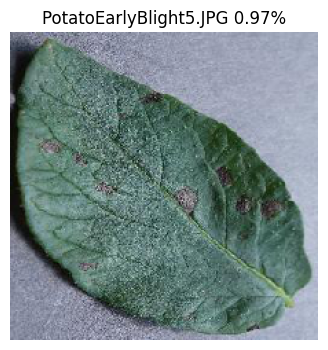

1/1 [==============================] - 0s 26ms/step


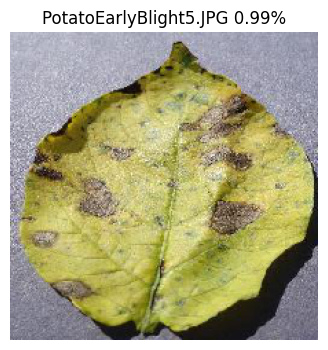

1/1 [==============================] - 0s 29ms/step


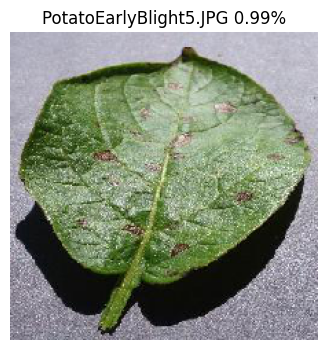

1/1 [==============================] - 0s 28ms/step


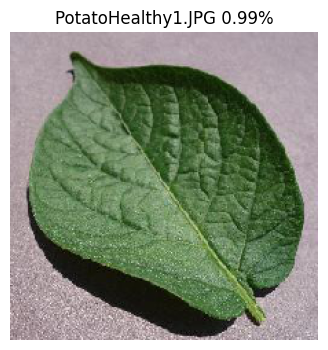

1/1 [==============================] - 0s 23ms/step


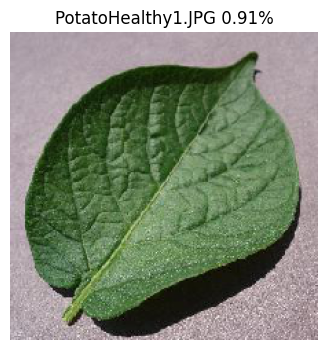

1/1 [==============================] - 0s 32ms/step


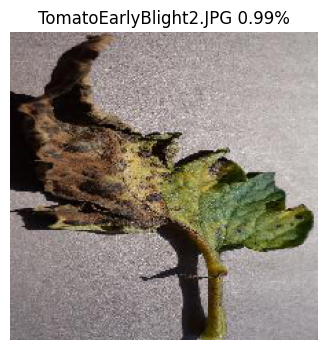

1/1 [==============================] - 0s 24ms/step


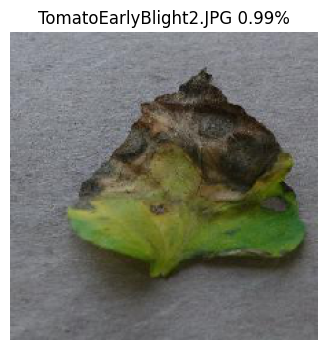

1/1 [==============================] - 0s 29ms/step


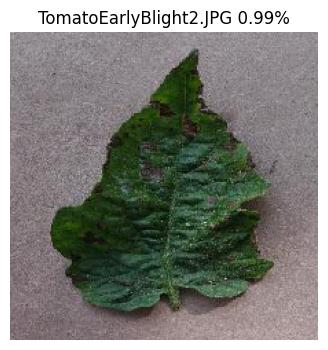

1/1 [==============================] - 0s 25ms/step


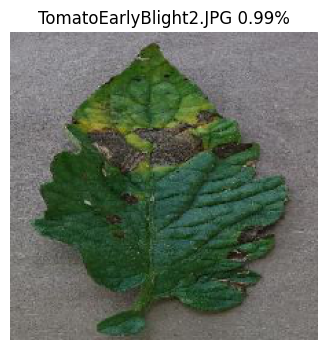

1/1 [==============================] - 0s 27ms/step


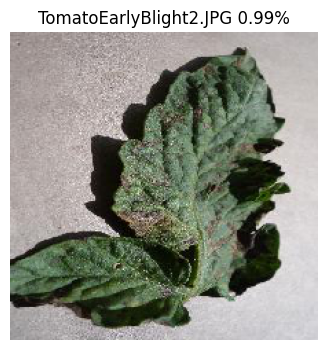

1/1 [==============================] - 0s 30ms/step


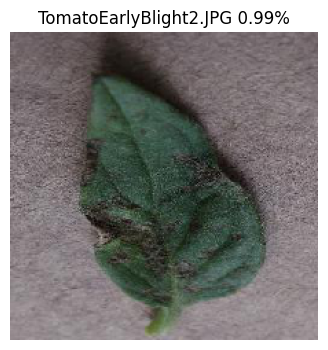

1/1 [==============================] - 0s 31ms/step


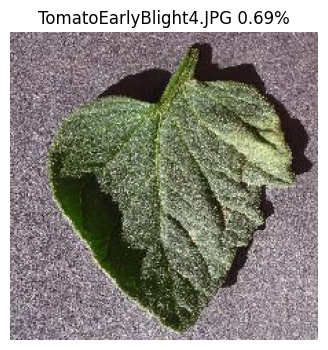

1/1 [==============================] - 0s 32ms/step


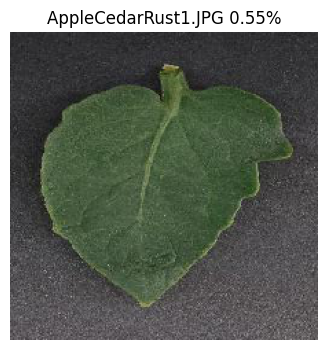

1/1 [==============================] - 0s 33ms/step


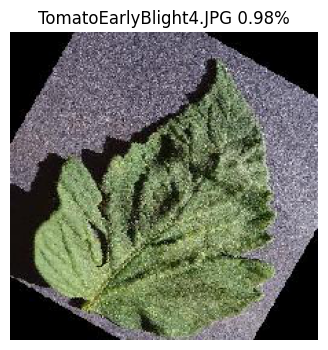

1/1 [==============================] - 0s 30ms/step


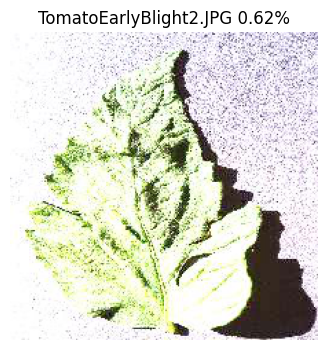

1/1 [==============================] - 0s 33ms/step


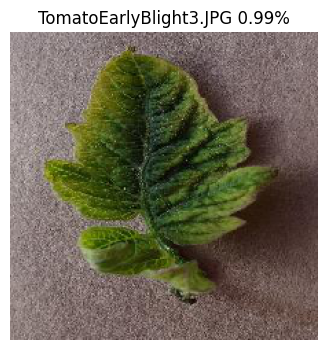

In [ ]:
directory="/content/drive/MyDrive/new/test/test"
files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]
for i in range(0,25):
    image_path = files[i]
    new_img =keras.utils.load_img(image_path, target_size=(224,224))
    img = keras.utils.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    prediction = classifier.predict(img)
    probabilty = prediction.flatten()
    max_prob = probabilty.max()
    index=prediction.argmax(axis=-1)[0]
    class_name = Test_images[index]
    #ploting image with predicted class name        
    plt.figure(figsize = (4,4))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(class_name+" "+ str(max_prob)[0:4]+"%")
    plt.show()

In [ ]:
print(len(images_each_class))

18
